# Auto-Sklearn Hands-On


Great to have you here ♥

This notebook is part of the **Auto-sklearn Hands-On Session** for the [1st AutoML Fall school](https://sites.google.com/view/automlschool21/home). To edit this notebook, please copy it to your Google drive (`File` ➡ `Save a Copy in Drive`).

Here, you will learn to do the following:

  1. How to apply auto-sklearn to a dataset
  2. How to inspect the results after running auto-sklearn
  3. How to modify and edit auto-sklearn to yield more efficient/explainable/robust outcomes

For this, this notebook is divided in the following sections

  1. [Setup](https://colab.research.google.com/drive/1p8nc5aQ_spI-ofug2R9vB-Xd5tMyZlWC#scrollTo=hEw8rqJS_NSo&line=1&uniqifier=1)
  2. [Task 1: Build your own pipeline](https://colab.research.google.com/drive/1p8nc5aQ_spI-ofug2R9vB-Xd5tMyZlWC#scrollTo=uwFOTKanT8Mj&line=1&uniqifier=1)
  3. [Task 2: Run Auto-Sklearn](https://colab.research.google.com/drive/1p8nc5aQ_spI-ofug2R9vB-Xd5tMyZlWC#scrollTo=Ai3pgJLOUD3L&line=1&uniqifier=1)
  4. [Task 3: Modify Auto-Sklearn](https://colab.research.google.com/drive/1p8nc5aQ_spI-ofug2R9vB-Xd5tMyZlWC#scrollTo=77lvPe0JMi6s)

For each task, we first describe the 📓**what** and ❓**why** of the tasks and the expected ✅**outcome** followed by some code you need to modify.

For more details on the method or implementation, we refer you to our [publications](https://www.automl.org/automl/auto-sklearn/), our blogposts on [automl.org](https://www.automl.org/automl-blog/) and *of course*, the documentation on [GitHub](https://automl.github.io/auto-sklearn/master/) ✨

Auto-sklearn is drop-in replacement for any scikit-learn estimator and this is how it works:

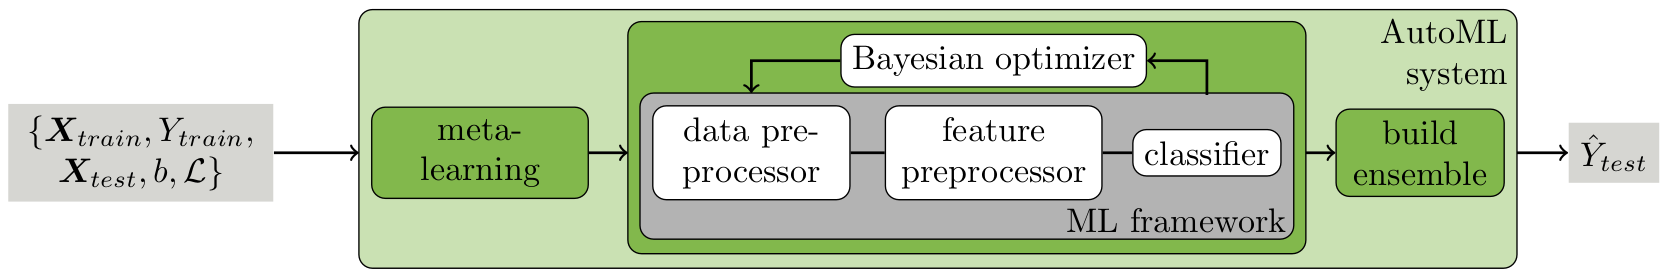


It is based on state-of-the-art AutoML technology and the well-known [scikit-learn](https://scikit-learn.org/stable/) library to provide **hands-free machine learning**.

# 1. Setup

### 1a) Install Auto-sklearn

In order to run this code, we are going to first install Auto-sklearn using pip. For more instructions on how to install Auto-sklearn, for example using conda, please check [this](https://automl.github.io/auto-sklearn/master/installation.html).

**IMPORTANT: After installing all dependencies you need to restart the COLAB runtime (`Runtime` -> `Restart Runtime`) to have access to the newly installed packages!**

In [1]:
!pip uninstall --yes nvidia-ml-py3
!pip uninstall --yes pandas-profiling
!pip uninstall --yes scipy
!pip install scipy==1.7.2
!pip install pandas-profiling
!pip install auto-sklearn==0.14.0

Found existing installation: pandas-profiling 3.1.0
Uninstalling pandas-profiling-3.1.0:
  Successfully uninstalled pandas-profiling-3.1.0
Found existing installation: scipy 1.7.2
Uninstalling scipy-1.7.2:
  Successfully uninstalled scipy-1.7.2
  Using cached scipy-1.7.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)


❗**Reminder: Restart the notebook before proceeding**

### 1b) Load Data and Define a Scoring Function

We will use the [credit-g](https://www.openml.org/d/31) dataset throughout this session. This datasets is a **binary classification task** and classifies credit requests into `good` or `bad` based on attributes, e.g. `amount`, `credit history` and `purpose of the credit`. We score a model based on the area under the [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

For this, we download the data, immediately split off the test set and define a scoring function.

In [2]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

def get_data_and_scoring_function():
    # From OpenML: https://www.openml.org/d/31
    X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
      X, y, random_state=42
    )
    def scoring_function(estimator):        
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)
    def train_scoring_function(estimator):        
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)
    return X_train, y_train, scoring_function, train_scoring_function

X_train, y_train, scoring_function, train_scoring_function = get_data_and_scoring_function()

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

### 1c) Visualize Data (Optional) 

In [3]:
import pandas as pd
complete_df = pd.concat([y_train, X_train], axis=1)

In [4]:
complete_df.describe(include='all')

class checking_status  ...  own_telephone foreign_worker
count    750             750  ...            750            750
unique     2               4  ...              2              2
top     good     no checking  ...           none            yes
freq     522             297  ...            429            722
mean     NaN             NaN  ...            NaN            NaN
std      NaN             NaN  ...            NaN            NaN
min      NaN             NaN  ...            NaN            NaN
25%      NaN             NaN  ...            NaN            NaN
50%      NaN             NaN  ...            NaN            NaN
75%      NaN             NaN  ...            NaN            NaN
max      NaN             NaN  ...            NaN            NaN

[11 rows x 21 columns]

In [5]:
import pandas_profiling
report = pandas_profiling.ProfileReport(complete_df, title="Pandas Profiling Report")
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Task 1: Build your own pipeline (BYOP; 15 minutes)

❓ **Why:** Even if you use AutoML methods, you should still take some time to understand the data and the pipeline you're going to use.

📓 **What:** Build your own scikit-learn pipeline

  1. Pre-process categorical and continuous features (if necessary)
  2. Choose a model type and train a predictive model
  3. Compute the score for your model
  4. Discuss the questions below 🔽 with your team members

If you are not familiar with scikit-learn you can find further information in the [docs](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators).

✅ **Outcome:** Questions to be discussed:

  1. Which model class have you used?
  2. What was your score?

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [7]:
complete_df.head()

class checking_status  ...  own_telephone foreign_worker
82   good     no checking  ...           none            yes
991  good     no checking  ...           none            yes
789   bad              <0  ...            yes            yes
894  good     no checking  ...            yes            yes
398   bad        0<=X<200  ...           none            yes

[5 rows x 21 columns]

In [8]:
# df_columns = complete_df.columns
# test_df = complete_df.copy()
# for column in df_columns:
#   test_df.loc[test_df[column] == 'none', column] = 0
# test_df.head()
# # df.loc[df['First Season'] > 1990, 'First Season'] = 1

In [9]:


# test_df = complete_df.fillna(0)
# # test_df = pd.get_dummies(complete_df)
# test_df.head()

In [10]:
# Import estimator and preprocessors you need
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Initialize your estimator
#------------------------- edit code here
# estimator_gradboost = DummyClassifier()
# estimator_gradboost = GaussianProcessClassifier()
estimator_gradboost = DecisionTreeClassifier()

names = [
    "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    # SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

for i, estimator_gradboost in enumerate(classifiers):
  # Design and fit the pipeline
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.dtypes == "category"),
          ('cont', 'passthrough', X_train.dtypes != "category"),
      ],
      remainder='passthrough',
  )

  pipeline_byop = Pipeline([
    ('preprocessor', preprocessor),
    ('gradboost', estimator_gradboost),
  ])
  #-------------------------

  pipeline_byop.fit(X_train, y_train) 

  # Score the pipeline
  print(f'Classifier {names[i]} achievies following scores: ')

  performance_byop = train_scoring_function(pipeline_byop)
  print(f"Train performance of my pipeline is {performance_byop}")

  performance_byop = scoring_function(pipeline_byop)
  print(f"Test performance of my pipeline is {performance_byop}")

  print('========================================================')

Classifier Nearest Neighbors achievies following scores: 
Train performance of my pipeline is 0.8575191570881227
Test performance of my pipeline is 0.5104556803995006
Classifier Gaussian Process achievies following scores: 
Train performance of my pipeline is 1.0
Test performance of my pipeline is 0.5078027465667915
Classifier Decision Tree achievies following scores: 
Train performance of my pipeline is 0.8549186663977952
Test performance of my pipeline is 0.736150124843945
Classifier Random Forest achievies following scores: 
Train performance of my pipeline is 0.831199166498622
Test performance of my pipeline is 0.6830134207240949
Classifier Neural Net achievies following scores: 
Train performance of my pipeline is 0.6364018283256032
Test performance of my pipeline is 0.5383114856429463
Classifier AdaBoost achievies following scores: 
Train performance of my pipeline is 0.8607246084560058
Test performance of my pipeline is 0.7398564294631711
Classifier Naive Bayes achievies followi

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# Task 2: Run Auto-sklearn (ASKL; 20 minutes)

❓ **Why:** You just manually built a predictive pipeline that works (pretty well). Now you're ready to use Auto-sklearn and learn how it produces predictions.

📓 **What:** Run Auto-sklearn on the credit-g dataset

  1. Run Auto-sklearn. Make sure that everyone at your table runs Auto-sklearn with a different setting, e.g. `resampling_strategy`, `ensemble_size`, `metric`,  (for more see [here](https://automl.github.io/auto-sklearn/master/api.html))
  2. Inspect the statistics
  3. Discuss the questions below 🔽 with your team members

✅ **Outcome:** While AutoML systems seemingly magically produce predictions, it is always a good to also understand how they work. Here are a few questions your boss, your client or your professor might ask you regarding using Auto-sklearn:

  * What's the final test performance?
  * Why is is worse than the final train performance?
  * How did the setting impact the result/statistics?
  * Was is better than your manually found optimizer?
  * What classifier type was used? Did you consider it when building your model manually?
  * What preprocessing was used?
  * What hyperparameters were used?
  * What do you expect to happen if one replaces cross-validation by holdout?
  * How many function evaluations did Auto-sklearn perform?
  * How could it find good models with only so little time?

➕ **A Few Notes On Debugging**

Not everything works at the first try. Here are a few recommendations for [debugging](http://www.phdcomics.com/comics/archive/phd011406s.gif): 

  * Check the statistics: `estimator_askl.sprint_statistics()`
  * Check the evaluated models: `estimator_askl.show_models()`
  * Check the logs: Click the 📁 icon on the left, navigate to `/tmp/` and open the relevant Auto-sklearn logs in one of the `autosklearn_tmp_*` folders)
  * If nothing helps, try restarting the runtime and notebook
  * Do a factory reset as a last resort

#### Task 2a: Fitting Auto-sklearn

In [37]:
import autosklearn.classification
import autosklearn.metrics

# Create and train an ensemble with AutoML 
estimator_askl = autosklearn.classification.AutoSklearnClassifier(
    #------------------------- edit code here
    time_left_for_this_task=120, # in seconds
    seed=42, 
    resampling_strategy='holdout',
    metric=autosklearn.metrics.roc_auc,
    n_jobs=4,
    #-------------------------
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl.fit(X_train, y_train, dataset_name='credit-g')

AutoSklearnClassifier(metric=roc_auc, n_jobs=4, per_run_time_limit=48, seed=42,
                      time_left_for_this_task=120)

In [38]:
print(estimator_askl.show_models())

[(1.000000, MyDummyClassifier(config=1,
                  init_params={'data_preprocessor:feat_type': {'age': 'numerical',
                                                               'checking_status': 'categorical',
                                                               'credit_amount': 'numerical',
                                                               'credit_history': 'categorical',
                                                               'duration': 'numerical',
                                                               'employment': 'categorical',
                                                               'existing_credits': 'numerical',
                                                               'foreign_worker': 'categorical',
                                                               'housing': 'categorical',
                                                               'installment_commitment': 'numerical',
                            

Auto-sklearn follows the scikit-learn API to specify how to run in parallel by providing the argument `n_jobs`. If `n_jobs >= 1` the respective number of cores is used, for `n_jobs is None` 1 core is used and for `n_jobs < 0` all available cores are used. If you set `n_jobs != 1`, run Auto-sklearn on your local machine and have [Bokeh](https://bokeh.org/) installed, you also get access to the [Dask dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) which shows how the individual training jobs of Auto-sklearn are executed in a distributed fashion.

In [39]:
performance_askl = train_scoring_function(estimator_askl)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")

Train Auto-Sklearn Classifier performance is 0.5
Test Auto-Sklearn Classifier performance is 0.5


In [13]:
# For compatibility with scikit-learn we implement `cv_results_`, but the output is pretty lengthy, so we leave this commented
# print(estimator_askl.cv_results_)

In [40]:
print(estimator_askl.show_models())

[(1.000000, MyDummyClassifier(config=1,
                  init_params={'data_preprocessor:feat_type': {'age': 'numerical',
                                                               'checking_status': 'categorical',
                                                               'credit_amount': 'numerical',
                                                               'credit_history': 'categorical',
                                                               'duration': 'numerical',
                                                               'employment': 'categorical',
                                                               'existing_credits': 'numerical',
                                                               'foreign_worker': 'categorical',
                                                               'housing': 'categorical',
                                                               'installment_commitment': 'numerical',
                            

In [ ]:
print(estimator_askl.sprint_statistics())

In [41]:
estimator_askl.leaderboard()

KeyError: ignored

# Task 3: Extend Auto-sklearn (EXTEND; 20 minutes)

❓ **Why:** Learn how to adapt the Auto-sklearn design space and understand the consequences of doing so.

📓 **What:** Extend Auto-sklearn with your own parameterized model

  1. Implement the new component. Some ideas are
    1. Re-add a [scikit-learn model](https://scikit-learn.org/stable/supervised_learning.html) (for classification)
    2. [XGBoost](https://github.com/dmlc/xgboost)
    3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
  2. Run auto-sklearn (restricted to only your component)
  3. Study the statistics
  3. Discuss the questions below 🔽 with your team members


✅ **Outcome:** We will ask you the following: 

  1. What component did you add?
  2. What's the score you obtained?
  3. What do you think happens to the meta-learning part of Auto-sklearn, i.e. the set of configuration Auto-sklearn uses to warmstart?

In [55]:
from xgboost import XGBClassifier

# First implement your model. As a guideline, we provide a copy of: 
# https://github.com/automl/auto-sklearn/blob/master/autosklearn/pipeline/components/classification/adaboost.py
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, \
    UniformIntegerHyperparameter, CategoricalHyperparameter

from autosklearn.pipeline.components.base import AutoSklearnClassificationAlgorithm
from autosklearn.pipeline.constants import DENSE, UNSIGNED_DATA, PREDICTIONS, SPARSE

class MyNewModel(AutoSklearnClassificationAlgorithm):
    def __init__(self, n_estimators, learning_rate, algorithm, max_depth,
                random_state=None):
        # All hyperparameters are args
        #------------------------- edit code here
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.algorithm = algorithm
        self.random_state = random_state
        self.max_depth = max_depth
        # self.estimator = None
        #-------------------------


    def fit(self, X, Y, sample_weight=None):
        # Fit the model
        #------------------------- edit code here
        import sklearn.ensemble
        import sklearn.tree

        self.n_estimators = int(self.n_estimators)
        self.learning_rate = float(self.learning_rate)
        self.max_depth = int(self.max_depth)
        base_estimator = sklearn.tree.DecisionTreeClassifier(max_depth=self.max_depth)
        # base_estimator = xgboost

        # estimator = sklearn.ensemble.AdaBoostClassifier(
        #     base_estimator=base_estimator,
        #     n_estimators=self.n_estimators,
        #     learning_rate=self.learning_rate,
        #     algorithm=self.algorithm,
        #     random_state=self.random_state
        # )
        # estimator = XGBClassifier()
        estimator =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

        estimator.fit(X, Y, sample_weight=sample_weight)
        #-------------------------
        self.estimator = estimator
        return self

    def predict(self, X):
        if self.estimator is None:
            raise NotImplementedError
        return self.estimator.predict(X)

    def predict_proba(self, X):
        if self.estimator is None:
            raise NotImplementedError()
        return self.estimator.predict_proba(X)

    @staticmethod
    def get_properties(dataset_properties=None):
        #------------------------- edit code here (optional)
        return {'shortname': 'MAB',
                'name': 'My AdaBoost Classifier',
                'handles_regression': False,
                'handles_classification': True,
                'handles_multiclass': True,
                'handles_multilabel': False,
                'handles_multioutput': False,
                'is_deterministic': True,
                'input': (DENSE, SPARSE, UNSIGNED_DATA),
                'output': (PREDICTIONS,)}
        #-------------------------

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        #------------------------- edit code here
        cs = ConfigurationSpace()

        n_estimators = UniformIntegerHyperparameter(
            name="n_estimators", lower=50, upper=500, default_value=50, log=False)
        learning_rate = UniformFloatHyperparameter(
            name="learning_rate", lower=0.01, upper=2, default_value=0.1, log=True)
        algorithm = CategoricalHyperparameter(
            name="algorithm", choices=["SAMME.R", "SAMME"], default_value="SAMME.R")
        max_depth = UniformIntegerHyperparameter(
            name="max_depth", lower=1, upper=10, default_value=1, log=False)

        cs.add_hyperparameters([n_estimators, learning_rate, algorithm, max_depth])
        #-------------------------
        return cs

In [56]:
from autosklearn.pipeline.components.classification import ClassifierChoice

# Now you can add your component
autosklearn.pipeline.components.classification.add_classifier(MyNewModel)
for name in ClassifierChoice.get_components():
    # this should also print the name of your model
    print(name)
  
# Create and train an ensemble with AutoML 
estimator_askl_mod = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    seed=42, 
    resampling_strategy='cv',
    metric=autosklearn.metrics.roc_auc,
    # It is possible to run Auto-sklearn in parallel with additional components 
    # if these components are in separate modules and the components are 
    # imported when using auto-sklearn 0.14.2. For this example we are using 
    # auto-sklearn 0.14.0 so it does not work yet
    n_jobs=1,
    # above is same as before, but here we restrict the design space to your new model
    include={
        'classifier': [
            'MyNewModel',
        ]
    },
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl_mod.fit(X_train, y_train, dataset_name='credit-g')

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd
MyNewModel


TypeError: ignored

In [19]:
performance_askl = train_scoring_function(estimator_askl_mod)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl_mod)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")

Train Auto-Sklearn Classifier performance is 0.9862539490488673
Test Auto-Sklearn Classifier performance is 0.7886235955056179


# Bonus Task 1: Explainability

❓ **Why:** To understand what features are important for producing a prediction.

📓 **What:** Apply feature importance methods to Auto-Sklearn. Auto-sklearn behaves like a scikit-learn estimator and thus any method that works with an scikit-learn estimator also works with Auto-sklearn. The [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) module offers some interesting features importance methods you can evaluate, and in this task you will use the permutation importance.

✅ **Outcome:** Discuss the questions below 🔽 with your team members


* Which features are important?
* Can Auto-sklearn's design space be restricted to provide only interpretable models?
* What other feature importance methods could be applied (blackbox or whitebox)?

In [20]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import numpy as np

**Note**: In order to compute meaningful explanations we need data that is distinct from the training data, in this case we re-purpose the test set. This will take roughly two minutes if you've used `resampling_strategy='cv'` and much less if you've used `resampling_strategy='holdout'`. If you have time, you can increase the number of repetitions to get more reliable feature importance scores. If applicable, you can also move from cross-validation to holdout to improve speed here.

While the code runs, you could for example [read up how feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) works.

In [21]:
def get_data_for_feature_importance():
    # From OpenML: https://www.openml.org/d/31
    X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
    _, X_test, _, y_test = sklearn.model_selection.train_test_split(
      X, y, random_state=42
    )
    return X_test, y_test

X_feature_importance, y_feature_importance,  = get_data_for_feature_importance()

r = permutation_importance(
    estimator_askl, X_feature_importance, y_feature_importance,
    n_repeats=2, random_state=0, n_jobs=-1,
    scoring='roc_auc',
)

KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_train.columns[i] for i in sort_idx], vert=False)
fig.show()
plt.show()

##### Other explainers

* Can use anything that works with sklearn
* [SHAP](https://github.com/slundberg/shap) can only be used for datasets without categorical features and without missing values
* [sklearn's partial dependency](https://scikit-learn.org/stable/modules/partial_dependence.html) plots only work for datasets without categorical features and without missing values
* We have such examples in a [EuroPython tutorial notebook](https://github.com/automl/auto-sklearn-talks/blob/main/2021_07_28_EuroPython/Tutorial-Regression.ipynb) and the [Auto-sklearn examples](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_inspect_predictions.html)

# Bonus Task 2: Hands-free AutoML via Auto-sklearn 2.0

❓ **Why:** Auto-Sklearn is just not good or fast enough for you? You're tired of deciding between CV or hold-out yourself and you really want to apply Successive Halving? Then try Auto-sklearn 2.0!

📓 **What:** We do have a new generation of AutoML system: Auto-sklearn 2.0 which aims at even more automation. Here, you'll see how to use it?

✅ **Outcome:** Discuss with your teammembers the differences to Auto-sklearn 1.0, e.g.

  * What are the main new components?
  * How does the new meta-learning work?
  * When would you apply crossvalidation, holdout and/or successive halving?
  * How does the final ensemble differ from the ensemble constructed by Auto-sklearn 1.0?

In [ ]:
import autosklearn.experimental.askl2
import autosklearn.metrics

# Create and train the estimator 
estimator_askl_2 = autosklearn.experimental.askl2.AutoSklearn2Classifier(
    time_left_for_this_task=120,
    n_jobs=4,
    seed=42,
    metric=autosklearn.metrics.roc_auc,
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl_2.fit(X_train, y_train)

In [ ]:
performance_askl = train_scoring_function(estimator_askl_2)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl_2)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")

# Bonus Task 3: Configuring SMAC

❓ Why: Auto-sklearn is built around [SMAC](https://github.com/automl/SMAC3) and allows configuring SMAC for custom behavior. This allows for maximal flexibility.

📓 What: This can be done in two ways:

1. By passing arguments to the [scenario](https://automl.github.io/SMAC3/master/pages/details/scenario.html).
2. By creating a callback function that, given a scenario, returns an instance of SMAC.

We'll have a look at examples for each and create our own custom version of SMAC for Auto-sklearn.

✅ Outcome: A custom Auto-sklearn that you can use to benchmark new algorithms.

*Note*: It is also possible that you only use the pipelines from Auto-sklearn and use your own optimizer which can be helpful if you want to benchmark or develop an entirely new algorithm that cannot be implemented within SMAC ([example](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_single_configuration.html)).


## Task 3a: Passing arguments to the scenario

The [scenario](https://automl.github.io/SMAC3/master/pages/details/scenario.html) defines the problem to be optimized by SMAC. However, creating this problem definition is the job of Auto-sklearn, so most of the arguments that could be passed to the scenario will be ignored by Auto-sklearn. A notable exception is the number of target algorithm runs, that is sometimes used as a stopping criterion. Your goal is to figure how to do so and make Auto-sklearn stop after four function evaluations.

In [ ]:
estimator_askl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120, # in seconds
    seed=42, 
    resampling_strategy='holdout',
    metric=autosklearn.metrics.roc_auc,
    n_jobs=4,
    #------------------------- edit code here
    smac_scenario_args={},
    #-------------------------
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl.fit(X_train, y_train, dataset_name='credit-g')

In [ ]:
performance_askl = train_scoring_function(estimator_askl)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")

## Task 3b: Using a callback function

We will use [Auto-sklearn's successive halving example](https://automl.github.io/auto-sklearn/master/examples/60_search/example_successive_halving.html) as the starting point for the callback function. It shows how to program a callback function to pass arguments to SMAC such that they effectively change the search strategy. Our goal is now to make user of the Auto-sklearn machinery, but only tune the reduced subspace of one algorithm: [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier). Because we know that for low-dimensional hyperparameter spaces Gaussian processes are the model of choice we want to use them.

Your goal is to write a callback function that uses SMAC's [blackbox facade](https://automl.github.io/SMAC3/master/apidoc/smac.facade.smac_bb_facade.html).

In [ ]:
def get_smac_object_callback():
    def get_smac_object(
        scenario_dict,
        seed,
        ta,
        ta_kwargs,
        metalearning_configurations,
        n_jobs,
        dask_client,
    ):
        raise NotImplementedError()
        
    return get_smac_object

In [ ]:
import autosklearn.classification

estimator_askl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=10,
    initial_configurations_via_metalearning=0,
    include={
        'classifier': ['gradient_boosting'],
        'feature_preprocessor': ['no_preprocessing']
    },
    get_smac_object_callback=get_smac_object_callback(),
)
estimator_askl.fit(X_train, y_train, dataset_name='credit-g')

print(estimator_askl.show_models())

performance_askl = train_scoring_function(estimator_askl)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")